# Demand

PyPSA-GB uses the ESPENI (Elexon Sum Plus Embedded Net Imports) dataset from https://zenodo.org/record/3884859. This is a cleaned dataset using both National Grid and Elexon data to develop historical half hourly electricity profiles which represent the total system demand of the GB. Essentially, system view data (from Elexon) is added to embedded generation, i.e., distribution-connected solar and wind, and interconnector imports (both from National Grid). Therefore, generation at distribution level and interconnectors should be added separately. This is available from 2008-11-06 up to 2021-06-06 (as of 2021-06-17). See https://doi.org/10.1016/j.esr.2021.100743 for the paper Calculating Great Britain's half-hourly electrical demand from publicly available data which describes the methodology for deriving this dataset.

Load distribution across buses from the Future Energy Scenario Regional Breakdown worksheet. Historical years use 2020 distribution for all timeperiods.

Future demand profiles are generated by scaling historical demand profiles according to FES data specific to different scenarios.

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature

import imageio

from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point

from statistics import mean

import loads

## Historical data - ESPENI

Historical load data is included in the form of the ESPENI dataset. This provides the load profile for the whole GB power system. National Grid's FES2021 data includes a regional breakdown of projected demand by grid supply point which can be mapped to the nearest bus. The 2020 data for these regional breakdown is used to distribute the load across the buses for the historical years 2010-2020. The load distribution is plotted below for a three day period in December.

29


Text(0.5, 1.0, 'Reduced Network GB with Load Distribution for 1-3 December')

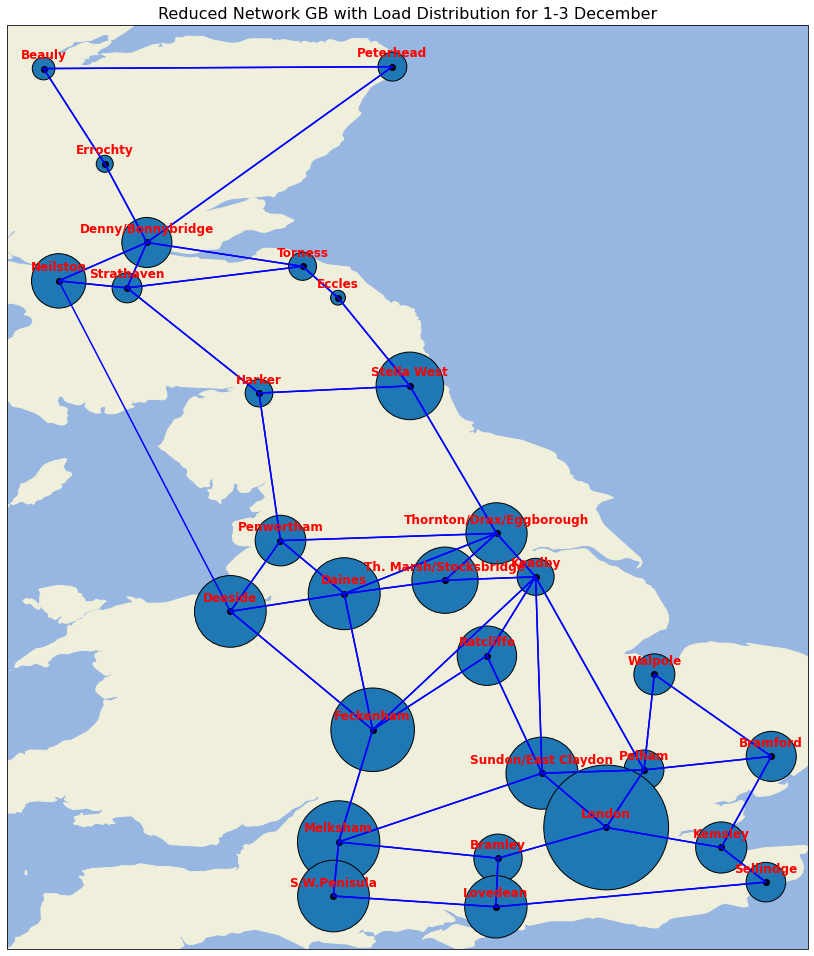

In [51]:
df_network = pd.read_csv('../data/network/buses.csv')[:29]
lon = df_network['x'].values
lat = df_network['y'].values

coordinates = np.zeros(shape=(len(lon), 2))
for i in range(len(lon)):
    coordinates[i][0] = lon[i]
    coordinates[i][1] = lat[i]

df_load = pd.read_csv('LOPF_data/loads-p_set.csv', index_col=0).iloc[:, :29]
sizes = df_load.sum(axis=0).values
marker_scaler = 0.00007

df_lines = pd.read_csv('../data/network/lines.csv', index_col=0)
df_buses = pd.read_csv('../data/network/buses.csv', index_col=0)

line_coordinates = []
for i in range(len(df_lines['bus0'].values)):

    bus0 = df_lines['bus0'].iloc[i]
    bus1 = df_lines['bus1'].iloc[i]
    bus0_coord = [df_buses['x'][bus0], df_buses['y'][bus0]]
    bus1_coord = [df_buses['x'][bus1], df_buses['y'][bus1]]
    line_coordinates.append([bus0_coord, bus1_coord])

fig = plt.figure()
fig.set_size_inches(15, 17)
ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)

for i in range(len(df_lines['bus0'].values)):
    ax.plot([line_coordinates[i][0][0], line_coordinates[i][1][0]],
            [line_coordinates[i][0][1], line_coordinates[i][1][1]],
            c='blue')
print(len(sizes * marker_scaler))
ax.scatter(lon, lat, s=sizes * marker_scaler, edgecolors='black')
ax.scatter(lon, lat, c='black', edgecolors='black')
for i, txt in enumerate(df_buses[:29].index):
    ax.annotate(txt, (lon[i], lat[i]),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center',
                fontweight='extra bold',
                color='red',
                fontsize='large')

ax.set_title('Reduced Network GB with Load Distribution for 1-3 December', fontsize=16)

The ESPENI dataset is plotted for the entire dataset, over 2020, and over 01/01/2020.

In [52]:
df_loads = loads.read_historical_demand_data()
df_loads.rename(columns={'POWER_ESPENI_MW': 'load'}, inplace=True)
# add columns with year, month, and weekday name
df_loads['Year'] = df_loads.index.year
df_loads['Month'] = df_loads.index.month

Text(0, 0.5, 'Load [MW]')

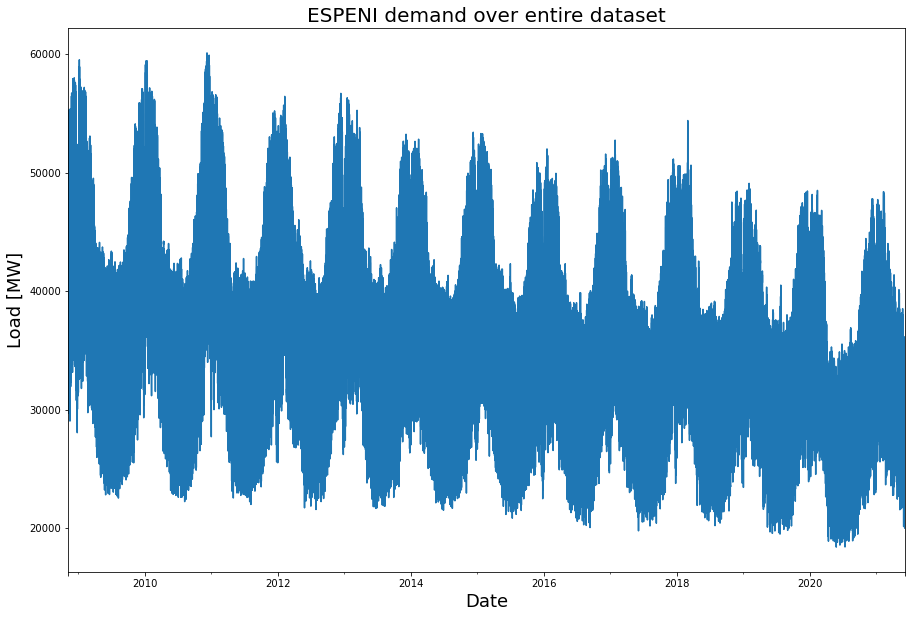

In [53]:
# Plot demand data
df_loads['load'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over entire dataset', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

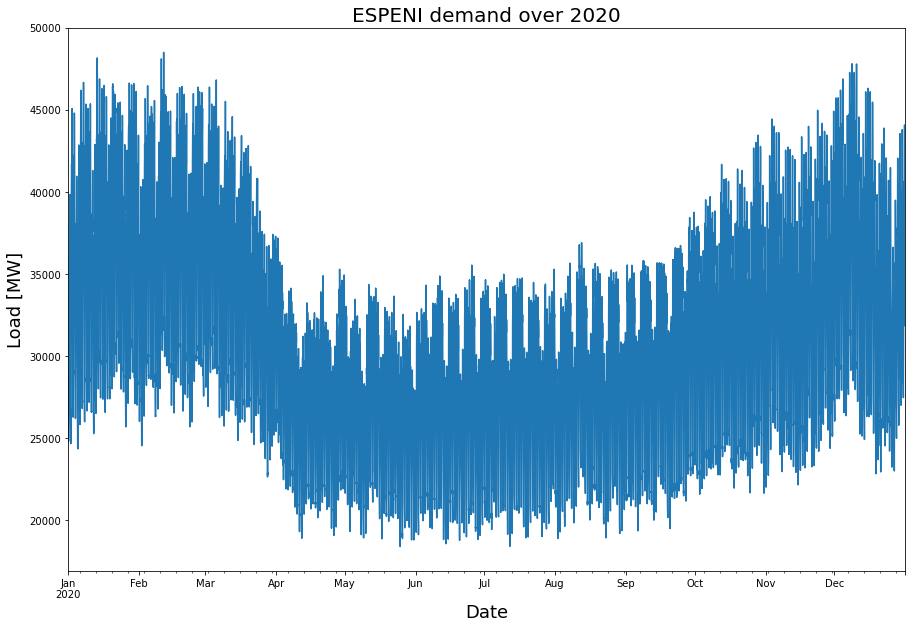

In [54]:
# Plot demand data
df_loads.loc['2020', 'load'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2020', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

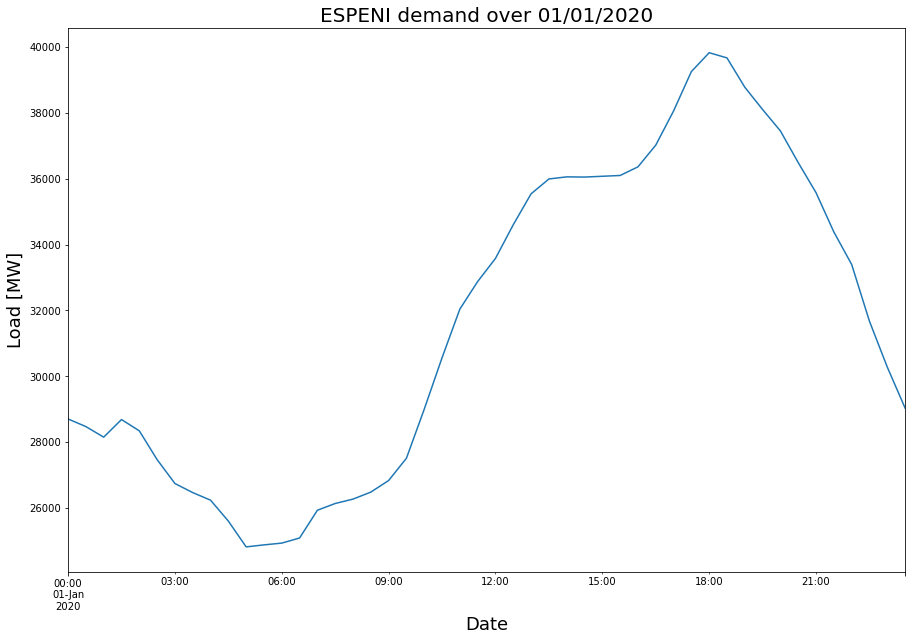

In [55]:
# Plot demand data
df_loads.loc['2020', 'load']['2020-01-01 00:00:00': '2020-01-01 23:30:00'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 01/01/2020', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Supply [kWh]')

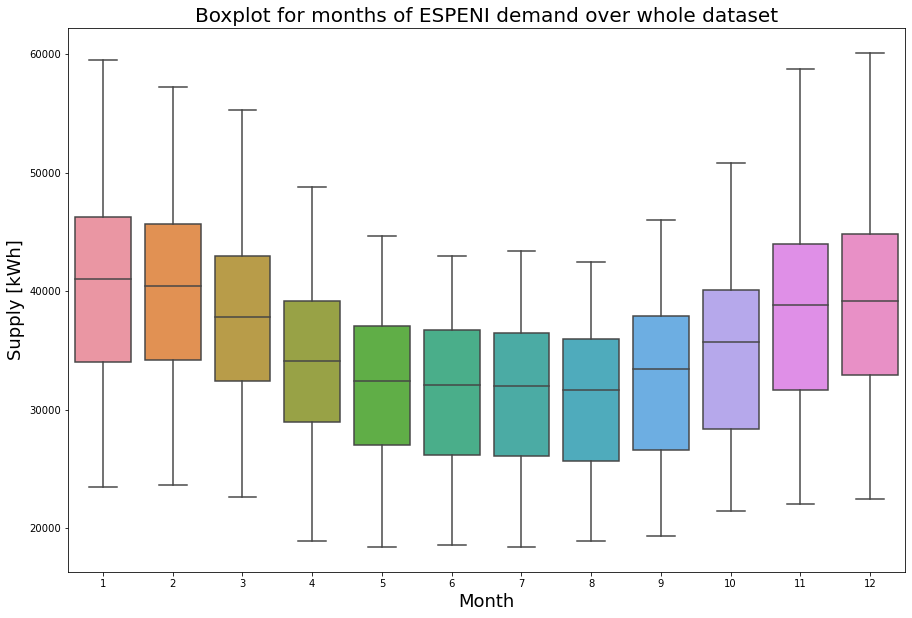

In [56]:
# Box plots over whole dataset for month values
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
sns.boxplot(data=df_loads, x='Month', y='load')
ax.set_title('Boxplot for months of ESPENI demand over whole dataset', fontsize=20)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Supply [kWh]', fontsize=18)

## Future data - FES2021

Future demand profiles are generated by scaling historical demand profiles to match the projected annual load from the FES2021 dataset. Different demand profiles from historical years can be chosen, and this along with the use of weather data forms the baseline year used to simulate future years. 

Distributions across buses are also obtained from FES2021 where data is available for distributions for the years 2020-2050 and all four scenarios.

In [57]:
start = '2050-01-01 00:00:00'
end = '2050-12-31 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 0.5

year_baseline = 2019

loads.write_loads(year)
loads.write_loads_p_set(start, end, year, time_step, year_baseline=year_baseline)

df_loads = pd.read_csv('LOPF_data/loads-p_set.csv', index_col=0)
df_loads

,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Bramford,Pelham,Sundon/East Claydon,Melksham,Bramley,London,Kemsley,Sellindge,Lovedean,S.W.Penisula
name,,,,,,,,,,,,,,,,,,,,,
2050-01-01 00:00:00,344.355716,558.886240,193.947235,1686.965699,1996.760548,604.448906,526.317230,148.145454,518.410526,3079.460303,...,1688.300283,1069.606749,3497.217334,4568.503846,1573.208859,10496.610559,1762.364772,1054.263148,2623.240880,3460.358091
2050-01-01 00:30:00,338.171563,548.849415,190.464211,1656.670125,1960.901487,593.593838,516.865300,145.484966,509.100589,3024.157449,...,1657.980742,1050.398089,3434.412141,4486.459828,1544.956201,10308.105933,1730.715135,1035.330038,2576.131097,3398.214840
2050-01-01 01:00:00,340.002975,551.821781,191.495695,1665.642039,1971.521006,596.808524,519.664452,146.272859,511.857690,3040.535171,...,1666.959754,1056.086657,3453.011651,4510.756839,1553.323114,10363.930832,1740.088049,1040.937003,2590.082473,3416.618318
2050-01-01 01:30:00,344.619138,559.313772,194.095599,1688.256179,1998.288013,604.911292,526.719848,148.258781,518.807096,3081.816002,...,1689.591785,1070.424967,3499.892606,4571.998622,1574.412319,10504.640168,1763.712931,1055.069629,2625.247585,3463.005167
2050-01-01 02:00:00,340.329117,552.351106,191.679384,1667.239777,1973.412153,597.381002,520.162931,146.413169,512.348681,3043.451751,...,1668.558756,1057.099690,3456.323892,4515.083704,1554.813112,10373.872253,1741.757199,1041.935504,2592.566964,3419.895650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-12-31 21:30:00,426.330239,691.930155,240.116738,2088.551042,2472.093135,748.339100,651.608032,183.411756,641.819123,3812.531593,...,2090.203326,1324.228638,4329.736468,5656.044741,1947.714173,12995.348356,2181.899005,1305.232464,3247.708283,4284.102814
2050-12-31 22:00:00,412.130520,668.884140,232.119205,2018.987980,2389.755494,723.414280,629.905020,177.302888,620.442148,3685.548166,...,2020.585232,1280.122750,4185.526574,5467.659692,1882.841944,12562.514204,2109.226817,1261.759279,3139.537342,4141.412833
2050-12-31 22:30:00,393.879115,639.262273,221.839691,1929.576094,2283.923984,691.377519,602.009363,169.450941,592.965559,3522.331834,...,1931.102611,1223.431878,4000.168450,5225.521666,1799.459353,12006.177020,2015.818659,1205.881642,3000.501371,3958.008308


Text(0, 0.5, 'Load [MW]')

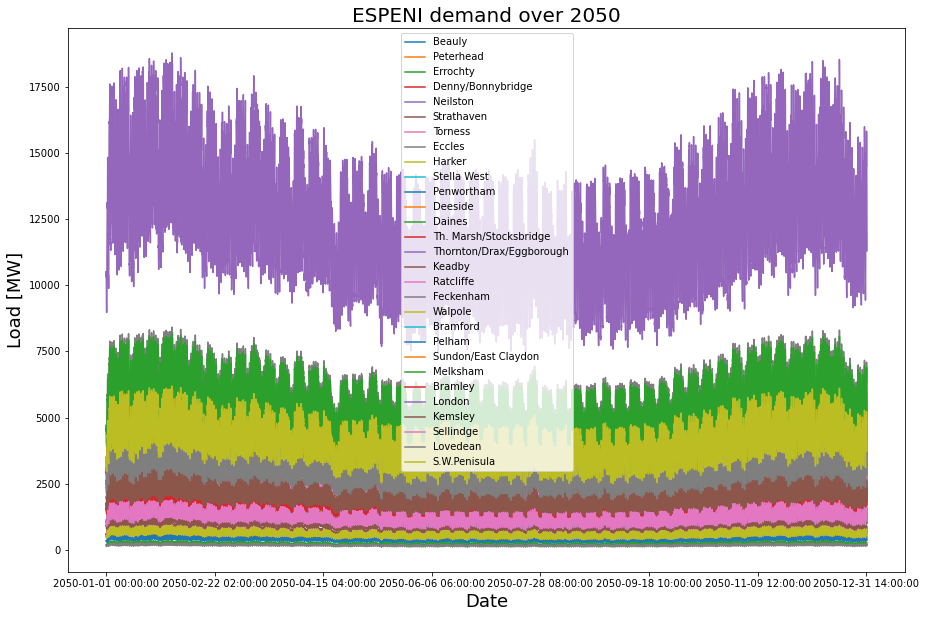

In [58]:
df_loads.plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2050', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

In [59]:
df_loads['Total'] = df_loads.sum(axis=1)
df_loads['Total']

name
2050-01-01 00:00:00    64741.136363
2050-01-01 00:30:00    63578.474982
2050-01-01 01:00:00    63922.792551
2050-01-01 01:30:00    64790.661493
2050-01-01 02:00:00    63984.109379
                           ...     
2050-12-31 21:30:00    80152.885093
2050-12-31 22:00:00    77483.244762
2050-12-31 22:30:00    74051.860768
2050-12-31 23:00:00    71627.487747
2050-12-31 23:30:00    69700.724363
Name: Total, Length: 17520, dtype: float64

Text(0, 0.5, 'Load [MW]')

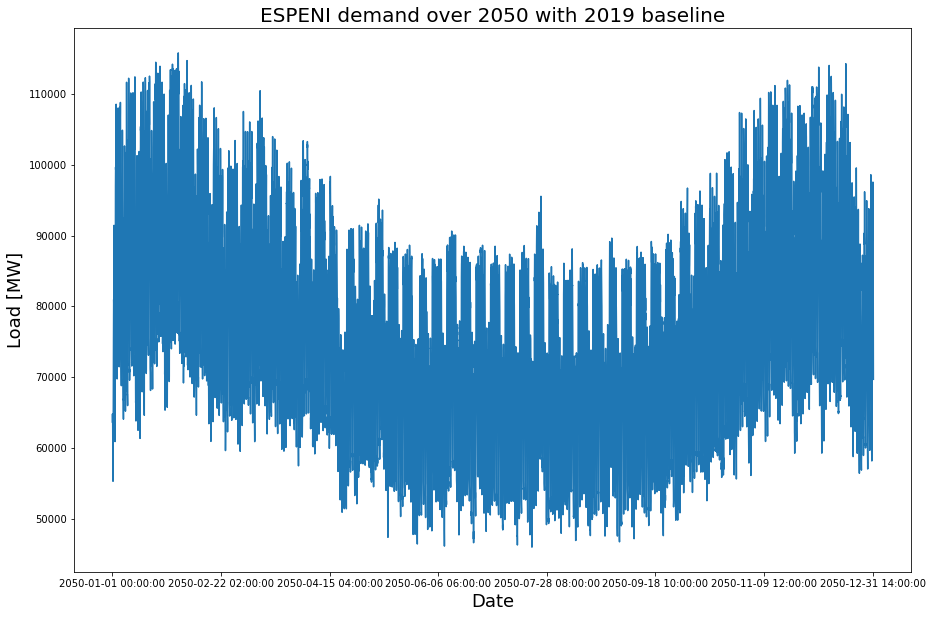

In [60]:
df_loads['Total'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2050 with 2019 baseline', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

In [61]:
df_FES = pd.read_excel(
            '../data/FES2021/FES 2021 Data Workbook V04.xlsx',
            sheet_name='ED1', header=4, dtype=str)
df_FES_demand = df_FES.loc[df_FES['Data item'] == 'GBFES System Demand: Total']
scenario = 'Leading the Way'
df_FES_demand = df_FES_demand.loc[df_FES_demand['Scenario'] == scenario]
date = str(year) + '-01-01 00:00:00'
df_FES_demand.columns = df_FES_demand.columns.astype(str)
# future demand in GWh/yr
future_demand = df_FES_demand[date].values[0]
print(future_demand + ' GWh/year' + ' future total system demand in ' + str(year) + ' from FES2021 workbook')

686266 GWh/year future total system demand in 2050 from FES2021 workbook


In [62]:
print(str(round(df_loads['Total'].sum() / 2000, 0)) + ' GWh/year' + ' future total system demand in ' + str(year) + ' from checking dataframe by summing')

686266.0 GWh/year future total system demand in 2050 from checking dataframe by summing


In [63]:
df_loads

,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Pelham,Sundon/East Claydon,Melksham,Bramley,London,Kemsley,Sellindge,Lovedean,S.W.Penisula,Total
name,,,,,,,,,,,,,,,,,,,,,
2050-01-01 00:00:00,344.355716,558.886240,193.947235,1686.965699,1996.760548,604.448906,526.317230,148.145454,518.410526,3079.460303,...,1069.606749,3497.217334,4568.503846,1573.208859,10496.610559,1762.364772,1054.263148,2623.240880,3460.358091,64741.136363
2050-01-01 00:30:00,338.171563,548.849415,190.464211,1656.670125,1960.901487,593.593838,516.865300,145.484966,509.100589,3024.157449,...,1050.398089,3434.412141,4486.459828,1544.956201,10308.105933,1730.715135,1035.330038,2576.131097,3398.214840,63578.474982
2050-01-01 01:00:00,340.002975,551.821781,191.495695,1665.642039,1971.521006,596.808524,519.664452,146.272859,511.857690,3040.535171,...,1056.086657,3453.011651,4510.756839,1553.323114,10363.930832,1740.088049,1040.937003,2590.082473,3416.618318,63922.792551
2050-01-01 01:30:00,344.619138,559.313772,194.095599,1688.256179,1998.288013,604.911292,526.719848,148.258781,518.807096,3081.816002,...,1070.424967,3499.892606,4571.998622,1574.412319,10504.640168,1763.712931,1055.069629,2625.247585,3463.005167,64790.661493
2050-01-01 02:00:00,340.329117,552.351106,191.679384,1667.239777,1973.412153,597.381002,520.162931,146.413169,512.348681,3043.451751,...,1057.099690,3456.323892,4515.083704,1554.813112,10373.872253,1741.757199,1041.935504,2592.566964,3419.895650,63984.109379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-12-31 21:30:00,426.330239,691.930155,240.116738,2088.551042,2472.093135,748.339100,651.608032,183.411756,641.819123,3812.531593,...,1324.228638,4329.736468,5656.044741,1947.714173,12995.348356,2181.899005,1305.232464,3247.708283,4284.102814,80152.885093
2050-12-31 22:00:00,412.130520,668.884140,232.119205,2018.987980,2389.755494,723.414280,629.905020,177.302888,620.442148,3685.548166,...,1280.122750,4185.526574,5467.659692,1882.841944,12562.514204,2109.226817,1261.759279,3139.537342,4141.412833,77483.244762
2050-12-31 22:30:00,393.879115,639.262273,221.839691,1929.576094,2283.923984,691.377519,602.009363,169.450941,592.965559,3522.331834,...,1223.431878,4000.168450,5225.521666,1799.459353,12006.177020,2015.818659,1205.881642,3000.501371,3958.008308,74051.860768


## Peak loads

Scaling the load profile according to the annual energy demand to generate future load profiles results in overestimation of peak demands.

The analysis below shows the FES2021 data peak to be 94.7 GW, but the generated future load profile have a peak of 115.8 GW. Applying a moving average can reduce the peak demand to 99.2 GW. A smoothing algorithm is not currently applied.

In [64]:
# Leading the way, 2050 Electricity System ACS (Average Cold Spell) Peak Demand GW
peak_FES = 94.7

In [65]:
df_loads.max()

Beauly                         615.806163
Peterhead                      999.447883
Errochty                       346.832933
Denny/Bonnybridge             3016.775465
Neilston                      3570.776950
Strathaven                    1080.926916
Torness                        941.205211
Eccles                         264.926294
Harker                         927.065772
Stella West                   5506.952687
Penwortham                    3082.161410
Deeside                       6189.332211
Daines                        6235.934595
Th. Marsh/Stocksbridge        5289.028020
Thornton/Drax/Eggborough      4514.522126
Keadby                        1650.378196
Ratcliffe                     4251.839548
Feckenham                     8409.920397
Walpole                       2025.619240
Bramford                      3019.162082
Pelham                        1912.761711
Sundon/East Claydon           6254.021323
Melksham                      8169.786931
Bramley                       2813

In [66]:
df_loads_smoothed = df_loads.rolling(48, min_periods=1).mean()
df_loads_smoothed.max()

Beauly                        528.027202
Peterhead                     856.983416
Errochty                      297.394268
Denny/Bonnybridge            2586.754736
Neilston                     3061.787094
Strathaven                    926.848170
Torness                       807.042840
Eccles                        227.162861
Harker                        794.918880
Stella West                  4721.974209
Penwortham                   2642.820361
Deeside                      5307.085195
Daines                       5347.044727
Th. Marsh/Stocksbridge       4535.113215
Thornton/Drax/Eggborough     3871.007844
Keadby                       1415.128061
Ratcliffe                    3645.768872
Feckenham                    7211.143707
Walpole                      1736.881058
Bramford                     2588.801157
Pelham                       1640.110599
Sundon/East Claydon          5362.553315
Melksham                     7005.239626
Bramley                      2412.322591
London          

Text(0, 0.5, 'Load [MW]')

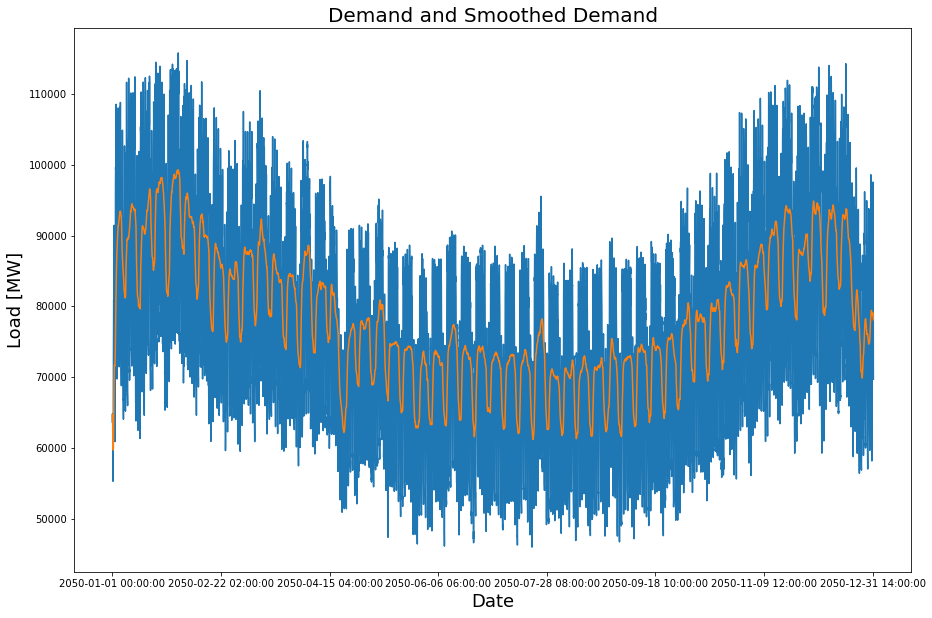

In [67]:
df_loads['Total'].plot(linestyle='-', figsize=(15,10))
df_loads_smoothed['Total'].plot(linestyle='-', figsize=(15,10))
plt.title('Demand and Smoothed Demand', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)